<center>
  <img src="https://digip.unibg.it/sites/dip3/files/logo-dip-it.svg">
  <h1><b>Crash course in Python </b> - AA 2024/2025</h1>
  <h2>Lezione 3 - Caso di studio ✏️</h2>
  <h3>A cura di <a href="https://github.com/lamferzon?tab=repositories">Lorenzo Leoni</a></h3>
</center>

# Importazione dei pacchetti 📄

In [121]:
import re
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importazione dei dati 💾

In [122]:
data = pd.read_csv("phone_data.csv")

# rinominazione delle colonne
data = data.rename(
    columns={col_i: col_i.lower().replace(" ", "_") for col_i in data.columns}
)

# alcune informazioni riguardanti il dataset
nrows, ncols = data.shape
print(f"Dimensioni del dataset \n- Numero di righe: {nrows}.\n- Numero di colonne: {ncols}.")
print("\nColonne del dataset e rispettivi tipi")
for col_i in data.columns:
    print(f"- {col_i.capitalize()} ({data[col_i].dtype}).")

Dimensioni del dataset 
- Numero di righe: 1715.
- Numero di colonne: 31.

Colonne del dataset e rispettivi tipi
- Phone_brand (object).
- Phone_model (object).
- Store (object).
- Price (float64).
- Currency (object).
- Price_usd (float64).
- Storage (int64).
- Ram (int64).
- Launch (object).
- Dimensions (object).
- Weight (float64).
- Display_type (object).
- Display_size (float64).
- Display_resolution (object).
- Os (object).
- Nfc (int64).
- Usb (object).
- Battery (int64).
- Features_sensors (object).
- Colors (object).
- Video (object).
- Chipset (object).
- Cpu (object).
- Gpu (object).
- Year (int64).
- Foldable (int64).
- Ppi_density (int64).
- Quantile_10 (object).
- Quantile_50 (float64).
- Quantile_90 (object).
- Price_range (object).


# Elaborazione preliminare 🔧

## Rimozione delle colonne superflue o ad alta cardinalità

In [123]:
print("Cardinalità delle colonne categoriche")
for col_i in data.columns:
    if data[col_i].dtype == object:
        print(f"- {col_i.capitalize()}: {len(data[col_i].unique())}.")

data = data.drop(
    columns=[
        "phone_model",
        "price",
        "currency",
        "launch",
        "display_type",
        "display_resolution",
        "os",
        "usb",
        "features_sensors",
        "colors",
        "video",
        "gpu",
        "quantile_10",
        "quantile_50",
        "quantile_90"
    ]
)

Cardinalità delle colonne categoriche
- Phone_brand: 22.
- Phone_model: 472.
- Store: 8.
- Currency: 3.
- Launch: 337.
- Dimensions: 397.
- Display_type: 262.
- Display_resolution: 68.
- Os: 213.
- Usb: 35.
- Features_sensors: 63.
- Colors: 416.
- Video: 164.
- Chipset: 158.
- Cpu: 128.
- Gpu: 76.
- Quantile_10: 8.
- Quantile_90: 8.
- Price_range: 3.


## Creazione della colonna `volume`

In [124]:
def get_volume(row):
    match = re.findall(r"([\d.]+) x ([\d.]+) x ([\d.]+) mm", row.dimensions)
    if match:
        height, width, thickness = match[0]
        return round(float(height)*float(width)*float(thickness), 2)
    else:
        None
data["volume"] = data.apply(get_volume, axis=1)

# rimozione della colonna "dimensions" e dei dati mancanti
data = data.drop(
    columns=[
        "dimensions"
    ]
).dropna().reset_index(drop=True)

## Creazione della colonna `chipset_brand`

In [125]:
def get_chipset_brand(row):
    return row.chipset.split()[0]
data["chipset_brand"] = data.apply(get_chipset_brand, axis=1)

## Creazione della colonna `chipset_production_process`

In [126]:
def get_chipset_production_process(row):
    match = re.search(r"\((\d+)\s*nm\)", row.chipset)
    if match:
        return int(match.group(1))
    else:
        None
data["chipset_production_process"] = data.apply(get_chipset_production_process, axis=1)

# rimozione della colonna "chipset" e dei dati mancanti
data = data.drop(
    columns=[
        "chipset"
    ]
).dropna().reset_index(drop=True)

## Creazione della colonna `cpu_cores`

In [127]:
core_map = {
    'Hexa': 6,
    'Octa': 8,
    'Quad': 4,
    'Nona': 9,
    'Deca': 10,
    'Dual': 2
}

def get_cpu_cores(row):
    
    # primo passa: ricerca dei prefissi come "Hexa", "Octa", "Quad", etc.
    for key, value in core_map.items():
        if key.lower() in row.cpu.lower():
            return int(value)
    
    # secondo passo: utilizzo di un'espressione regolare (regex) per cercare numeri seguiti da "-core"
    match = re.search(r'(\d+)-core', row.cpu, re.IGNORECASE)
    if match:
        return int(match.group(1))
    else:
        return None

data["cpu_cores"] = data.apply(get_cpu_cores, axis=1)

# rimozione della colonna "cpu" e dei dati mancanti
data = data.drop(
    columns=[
        "cpu"
    ]
).dropna().reset_index(drop=True)

## Conversione di tipo delle colonne `nfc`, `foldable` e `year`

In [128]:
data["phone_brand"] = data.phone_brand.str.capitalize()
data["nfc"] = data.nfc.replace(1, "Yes").replace(0, "Not")
data["foldable"] = data.foldable.replace(1, "Yes").replace(0, "Not")
data["year"] = data.year.astype(str)

## Classificazione delle variabili

In [129]:
target_var = "price_usd"
num_vars = [var_i for var_i in data.columns if ((data[var_i].dtype == float) | (data[var_i].dtype == int)) & (var_i != target_var)]
cat_vars = [var_i for var_i in data.columns if data[var_i].dtype == object]

## DataFrame dopo il processamento iniziale

In [130]:
data.sort_index(axis=1).sort_values(by="price_usd", ascending=False).head(10)

,battery,chipset_brand,chipset_production_process,cpu_cores,display_size,foldable,nfc,phone_brand,ppi_density,price_range,price_usd,ram,storage,store,volume,weight,year
1073,4800,Qualcomm,4.0,8.0,7.85,Yes,Yes,Huawei,426,high price,2361.66,12,512,Amazon DE,117667.16,239.0,2023
1573,4650,Google,4.0,8.0,8.00,Yes,Yes,Google,373,high price,2275.45,16,512,Amazon UK,118886.30,257.0,2024
1534,5150,Qualcomm,4.0,8.0,7.92,Yes,Yes,Honor,402,high price,2197.39,12,512,Amazon UK,98979.81,226.0,2024
1533,5150,Qualcomm,4.0,8.0,7.92,Yes,Yes,Honor,402,high price,2122.77,12,512,Amazon DE,98979.81,226.0,2024
1571,4650,Google,4.0,8.0,8.00,Yes,Yes,Google,373,high price,2049.08,16,512,Amazon DE,118886.30,257.0,2024
1549,4400,Qualcomm,4.0,8.0,7.60,Yes,Yes,Samsung,374,high price,2028.26,12,1000,Amazon UK,113982.96,239.0,2024
1546,4400,Qualcomm,4.0,8.0,7.60,Yes,Yes,Samsung,374,high price,2019.99,12,1000,Best Buy,113982.96,239.0,2024
1536,4780,Qualcomm,4.0,8.0,6.86,Yes,Yes,Xiaomi,460,high price,1999.00,12,512,AliExpress,94202.00,190.0,2024
1187,4400,Qualcomm,4.0,8.0,7.60,Yes,Yes,Samsung,373,high price,1919.99,12,1000,Samsung,122741.21,253.0,2023
768,4400,Qualcomm,4.0,8.0,7.60,Yes,Yes,Samsung,373,high price,1919.99,12,1000,Best Buy,127124.61,263.0,2022


# Analisi preliminare 🔬

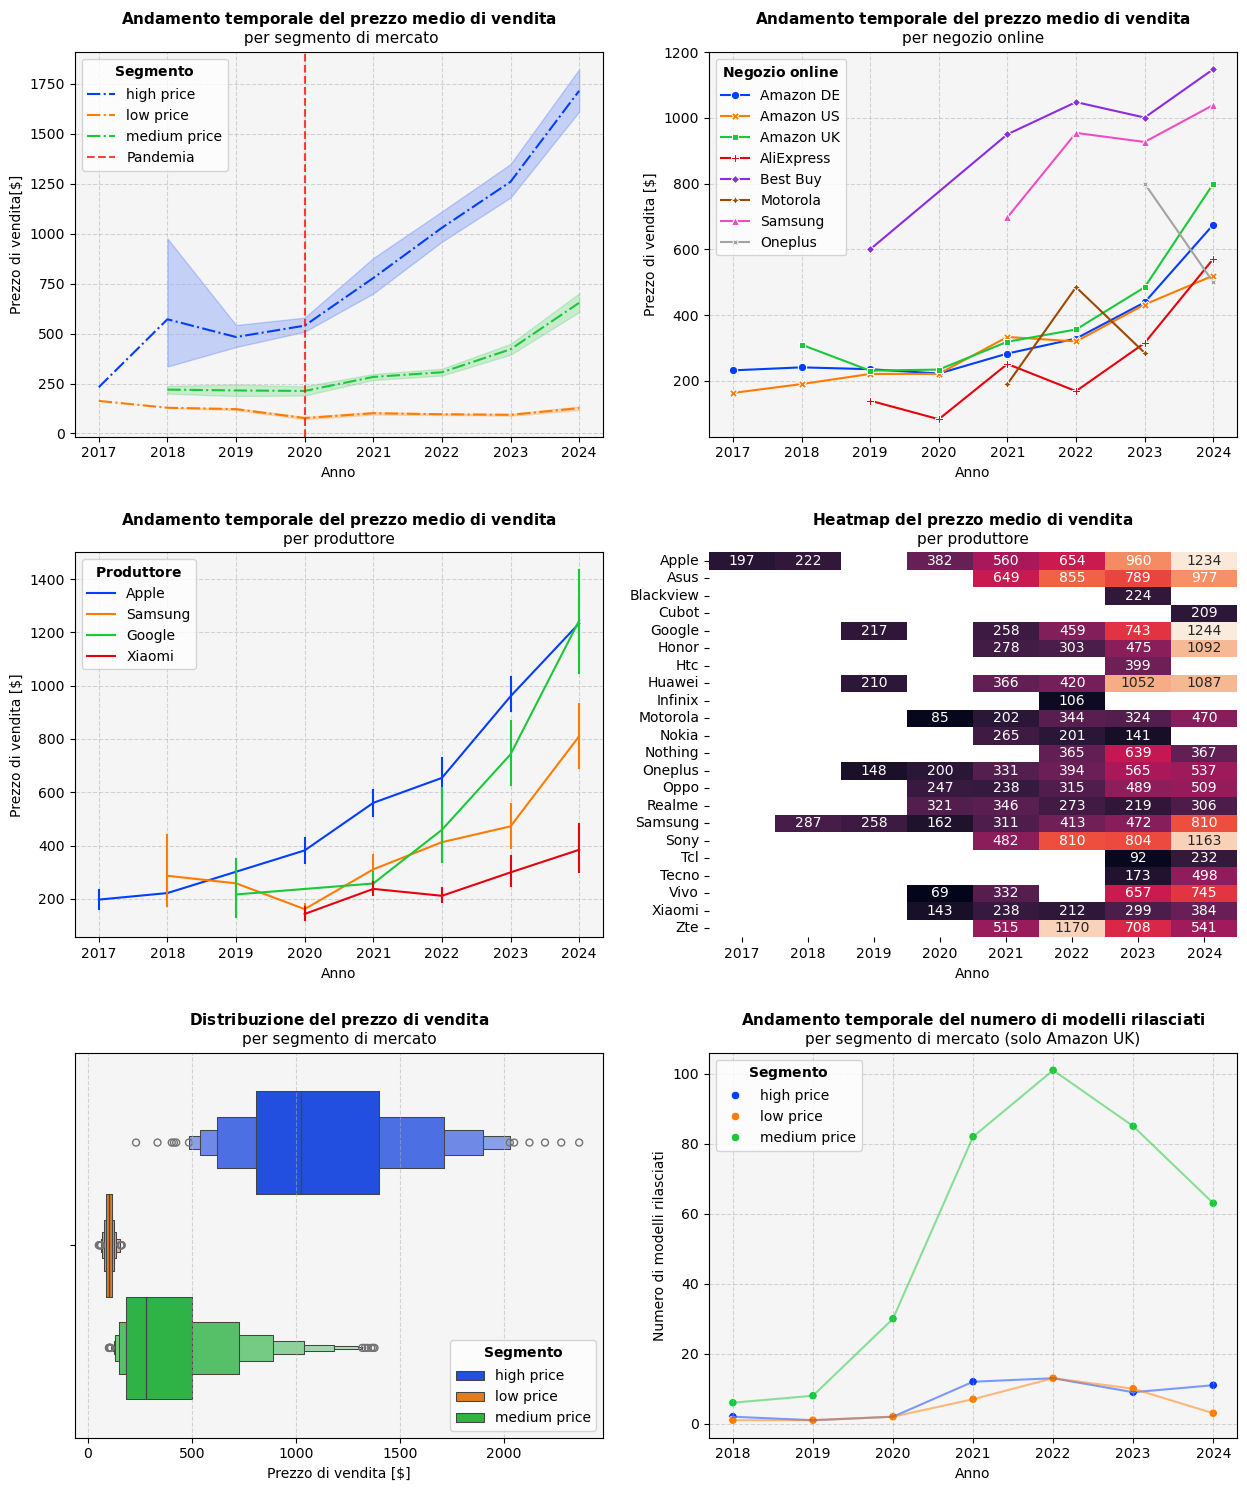

In [131]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=3,
    figsize=(15, 18)
)
fig.subplots_adjust(
    wspace=.2,
    hspace=.3
)

# andamento temporale del prezzo medio, per segmento di mercato
sns.lineplot(
    data=data,
    x="year",
    y="price_usd",
    ls="-.",
    hue="price_range",
    palette="bright",
    ax=axes[0, 0]
)
axes[0, 0].axvline(
    "2020",
    color="red",
    ls="--",
    alpha=.75,
    label="Pandemia"
)
axes[0, 0].set_title(
    "$\\mathbf{Andamento \\ temporale \\ del \\ prezzo \\ medio \\ di \\ vendita}$\n per segmento di mercato",
    size=11
)
axes[0, 0].set(
    xlabel="Anno",
    ylabel="Prezzo di vendita[$]",
    facecolor="whitesmoke"
)
axes[0, 0].grid(
    ls="--",
    alpha=.5
)
axes[0, 0].legend(
    title="$\\mathbf{Segmento}$"
)

# andamento temporale del prezzo medio, per negozio online
sns.lineplot(
    data=data,
    x="year",
    y="price_usd",
    hue="store",
    style="store",
    palette="bright",
    err_style=None,
    markers=True,
    dashes=False,
    ax=axes[0, 1]
)
axes[0, 1].set_title(
    "$\\mathbf{Andamento \\ temporale \\ del \\ prezzo \\ medio \\ di \\ vendita}$\nper negozio online",
    size=11
)
axes[0, 1].set(
    xlabel="Anno",
    ylabel="Prezzo di vendita [$]",
    facecolor="whitesmoke"
)
axes[0, 1].grid(
    ls="--",
    alpha=.5
)
axes[0, 1].legend(
    title="$\\mathbf{Negozio \\ online}$"
)

# andamento temporale del prezzo medio, per produttore
sns.lineplot(
    data=data[
        (data.phone_brand == "Samsung") | 
        (data.phone_brand == "Google") |
        (data.phone_brand == "Apple") |
        (data.phone_brand == "Xiaomi")
    ],
    x="year",
    y="price_usd",
    hue="phone_brand",
    palette="bright",
    err_style="bars",
    ax=axes[1, 0]
)
axes[1, 0].set_title(
    "$\\mathbf{Andamento \\ temporale \\ del \\ prezzo \\ medio \\ di \\ vendita}$\nper produttore",
    size=11
)
axes[1, 0].set(
    xlabel="Anno",
    ylabel="Prezzo di vendita [$]",
    facecolor="whitesmoke"
)
axes[1, 0].grid(
    ls="--",
    alpha=.5
)
axes[1, 0].legend(
    title="$\\mathbf{Produttore}$"
)

# heatmap del prezzo medio di vendita, per produttore
sns.heatmap(
    data.pivot_table(
        index="phone_brand",
        columns="year",
        values="price_usd",
        aggfunc="mean"
    ),
    annot=True,
    fmt=f".0f",
    cbar=False,
    ax=axes[1, 1]
)
axes[1, 1].set_title(
    "$\\mathbf{Heatmap\\ del \\ prezzo \\ medio \\ di \\ vendita}$\nper produttore",
    size=11
)
axes[1, 1].set(
    xlabel="Anno",
    ylabel=None
)

# distribuzione del prezzo medio, per segmento di mercato
sns.boxenplot(
    data=data,
    x="price_usd",
    hue="price_range",
    palette="bright",
    ax=axes[2, 0]
)
axes[2, 0].set_title(
    "$\\mathbf{Distribuzione \\ del \\ prezzo \\ di \\ vendita}$\nper segmento di mercato",
    size=11
)
axes[2, 0].set(
    xlabel="Prezzo di vendita [$]",
    facecolor="whitesmoke"
)
axes[2, 0].grid(
    axis="x",
    ls="--",
    alpha=.5
)
axes[2, 0].legend(
    title="$\\mathbf{Segmento}$"
)

# andamento temporale del numero di modelli rilasciati, per segmento di mercato (solo Amazon UK)
sns.lineplot(
    data=data[data["store"] == "Amazon UK"].groupby(["year", "price_range"]).agg(count=("price_range", "count")).reset_index(),
    x="year",
    y="count",
    hue="price_range",
    palette="bright",
    alpha=.5,
    legend=False,
    ax=axes[2, 1]
)
sns.scatterplot(
    data=data[data["store"] == "Amazon UK"].groupby(["year", "price_range"]).agg(count=("price_range", "count")).reset_index(),
    x="year",
    y="count",
    hue="price_range",
    palette="bright",
    ax=axes[2, 1]
)
axes[2, 1].set_title(
    "$\\mathbf{Andamento \\ temporale \\ del \\ numero \\ di \\ modelli \\ rilasciati}$\nper segmento di mercato (solo Amazon UK)",
    size=11
)
axes[2, 1].set(
    xlabel="Anno",
    ylabel="Numero di modelli rilasciati",
    facecolor="whitesmoke"
)
axes[2, 1].grid(
    ls="--",
    alpha=.5
)
axes[2, 1].legend(
    title="$\\mathbf{Segmento}$"
);

# Trasformazioni e rimozione degli outlier ⛔

## Applicazione del logaritmo naturale

### **Obiettivo**
Convertire le variabili numeriche con distribuzioni asimmetriche in distribuzioni più simmetriche, rendendo le relazioni tra variabili più lineari.

### **Formula**
$x_{\text{trasformato}} = \log(x + c)$
- $x$ è il valore originale.
- $c$ è una costante per evitare $\log(0)$ (solitamente $c=[0, 1]$).

### **Note** 
- Riduce la varianza.
- Evidenzia le relazioni lineari nascoste.
- Applicabile solo a valori positivi. Per gestire valori nulli o negativi, è necessario aggiungere una costante $c > 0$.

## Standardizzazione

### **Obiettivo**
Rendere le variabili numeriche comparabili, eliminando gli effetti delle diverse scale.

### **Formula:**
$x_{\text{standardizzato}} = \frac{x - \mu}{\sigma}$
- $x$ è il valore originale.
- $\mu$ è la media della variabile.
- $\sigma$ è la deviazione standard della variabile.

### **Note** 
  - Centra le variabili attorno a zero.
  - Rende la varianza unitaria.
  - Evita che variabili con scale maggiori dominino il modello.

In [132]:
tr_data = data.copy()
scaler = {}

for var_i in num_vars + [target_var]:
    
    # applicazione del logaritmo
    x = np.log(np.array(tr_data[var_i]).reshape(-1, 1))

    # standardizzazione
    scaler[var_i] = StandardScaler()
    tr_data[var_i] = scaler[var_i].fit_transform(x)

## Rimozione degli outlier tramite IQR (Interquartile Range)

### **Obiettivo**
Eliminare valori estremi che potrebbero distorcere i risultati della regressione.

### **Procedimento**
  - $\text{IQR} = Q3 - Q1$.
  - $\text{lower-bound} = Q1 - 1.5 \times \text{IQR}$.
  - $\text{upper-bound} = Q3 + 1.5 \times \text{IQR}$.
  - Rimuovere i valori $x$ che soddisfano $x < Q1 - (1.5 \cdot \text{IQR}) \ \text{oppure} \ x > Q3 + (1.5 \cdot \text{IQR})$.

In [133]:
for var_i in num_vars + [target_var]:
    
    if var_i != "cpu_cores":
        
        # calcolo dei quantili e dell'IQR
        Q1 = tr_data[var_i].quantile(0.25)
        Q3 = tr_data[var_i].quantile(0.75)
        IQR = Q3 - Q1
        
        # filtraggio
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        tr_data = tr_data[(tr_data[var_i] >= lower_bound) & (tr_data[var_i] <= upper_bound)]

## Confronto tra le distribuzioni dei dati originali e trasformati

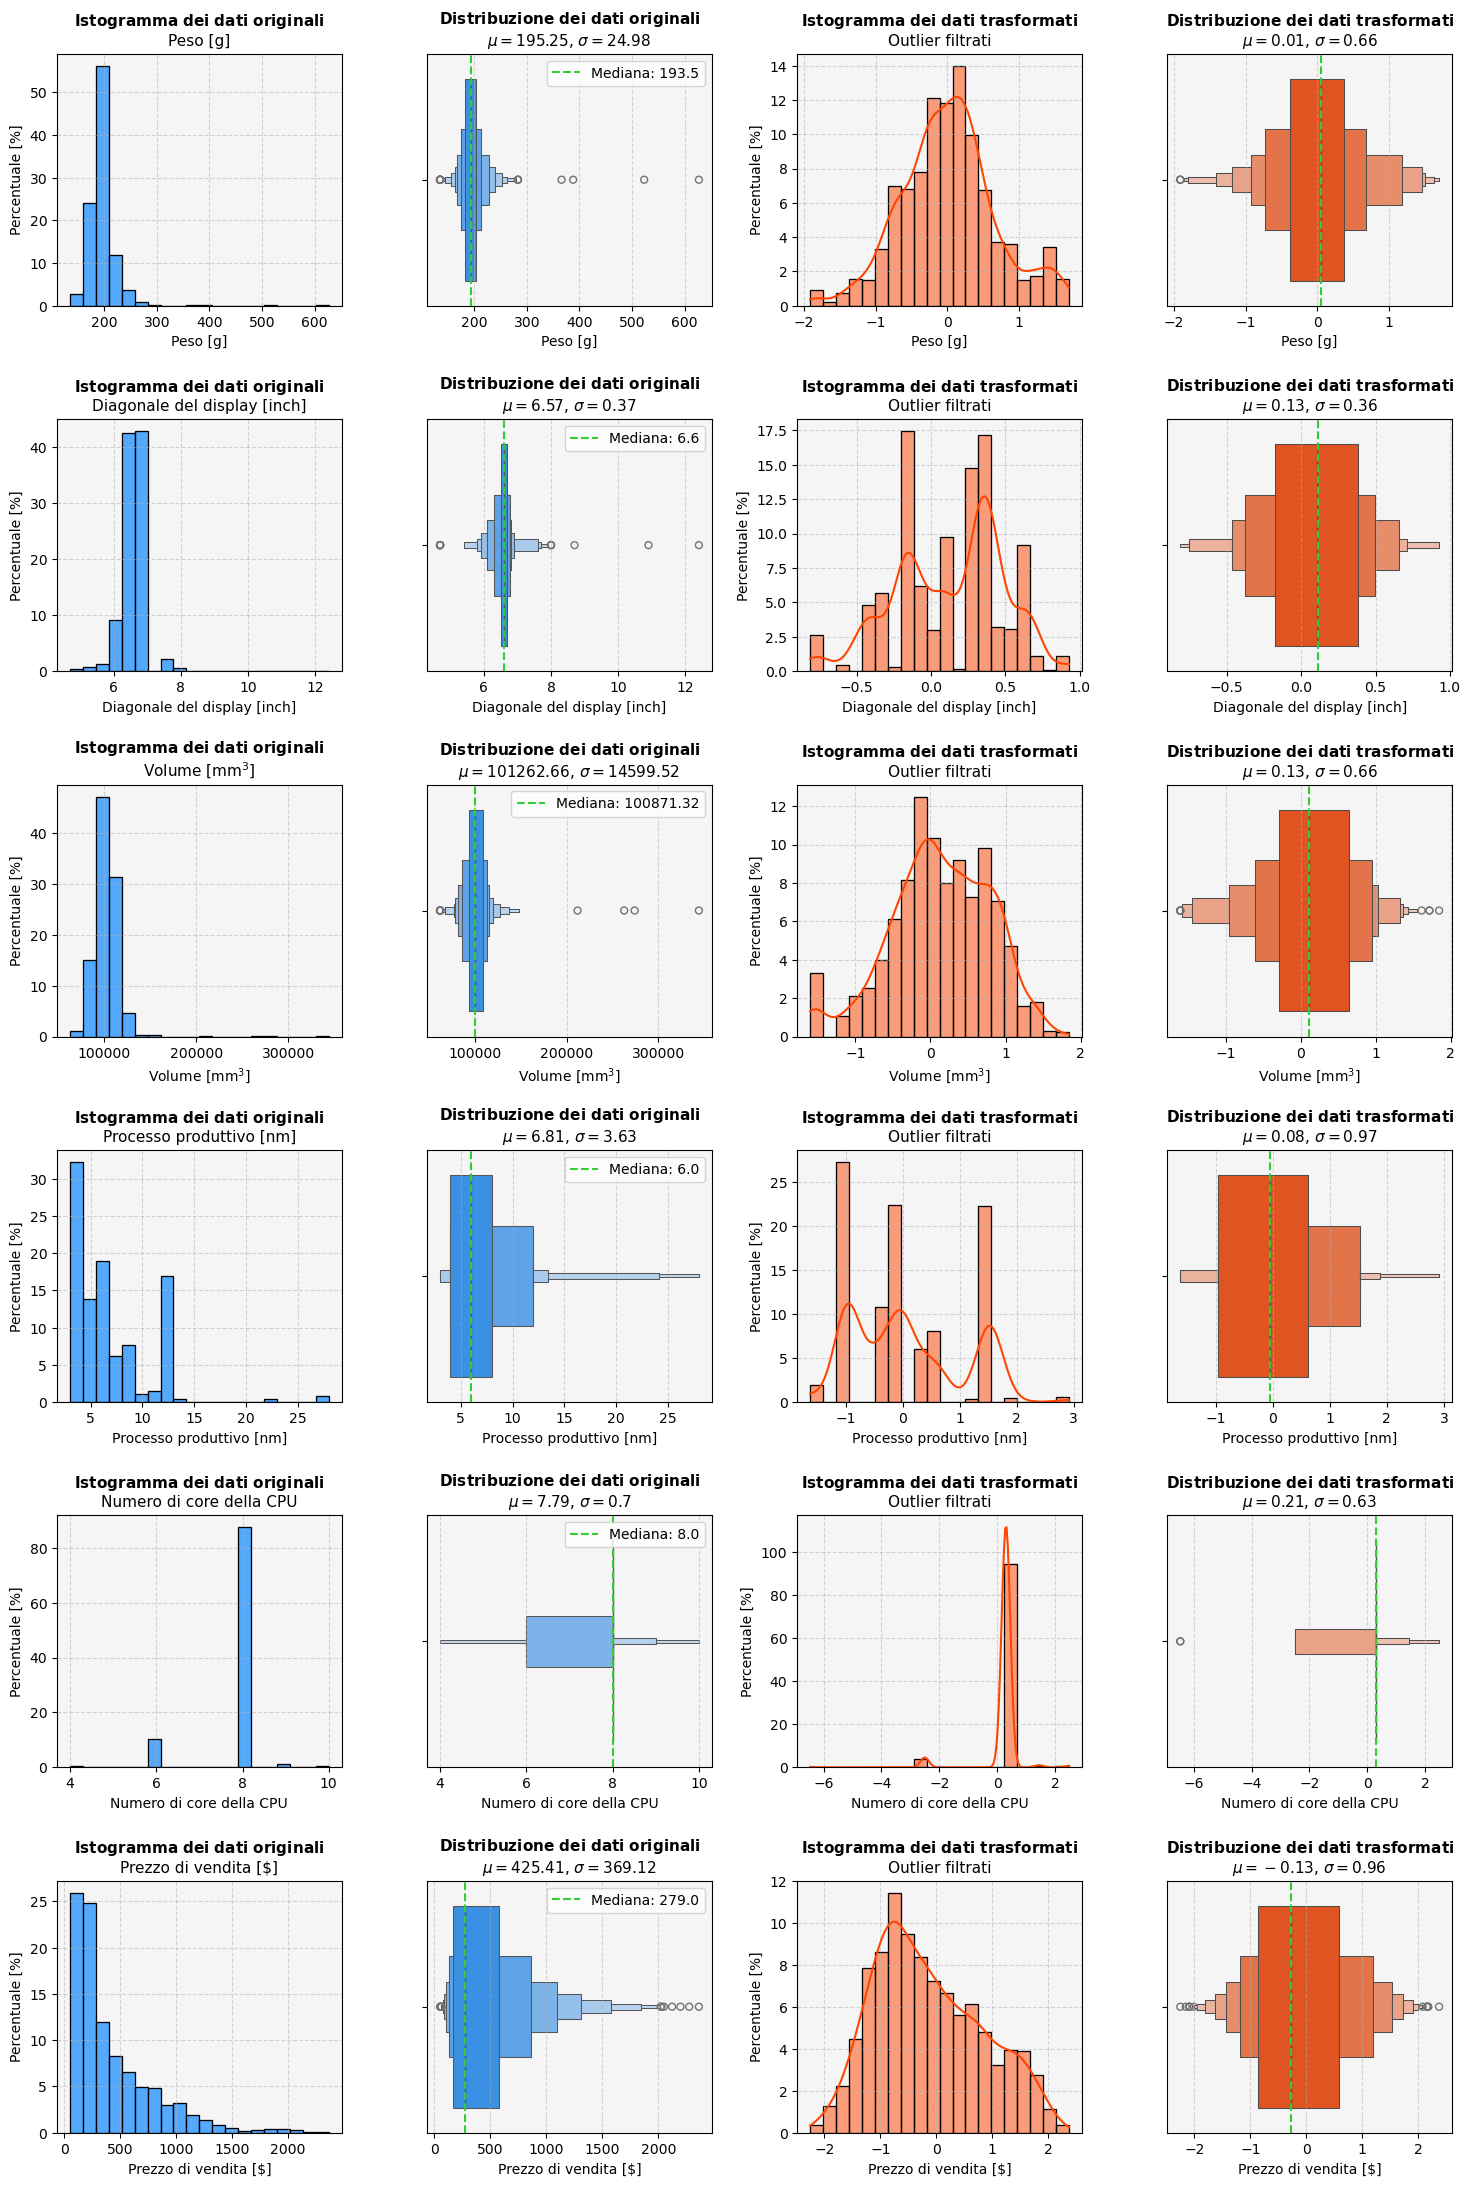

In [134]:
map = {
    "weight": "Peso [g]",
    "display_size": "Diagonale del display [inch]",
    "volume": "Volume [mm$^3$]",
    "chipset_production_process": "Processo produttivo [nm]",
    "cpu_cores": "Numero di core della CPU",
    "price_usd": "Prezzo di vendita [$]"
}

fig, axes = plt.subplots(
    ncols=4,
    nrows=len(num_vars + [target_var]),
    figsize=(18, 4.5*len(num_vars + [target_var]))
)
fig.subplots_adjust(
    wspace=.3,
    hspace=.45
)

for i, var_i in enumerate(num_vars + [target_var]):
    
    # istogramma dei dati originali
    sns.histplot(
        data=data,
        x=var_i,
        color="dodgerblue",
        stat="percent",
        bins=20,
        ax=axes[i, 0]
    )
    axes[i, 0].set_title(
        "$\\mathbf{Istogramma \\ dei \\ dati \\ originali}$\n" + map[var_i],
        size=11
    )
    axes[i, 0].set(
        xlabel=map[var_i],
        ylabel="Percentuale [%]",
        facecolor="whitesmoke"
    )
    axes[i, 0].grid(
        ls="--",
        alpha=.5
    )
    
    # distribuzione dei dati originali
    src_mu = round(data[var_i].mean(), 2)
    src_std = round(data[var_i].std(), 2)
    src_median = round(data[var_i].median(), 2)
    sns.boxenplot(
        data=data,
        x=var_i,
        color="dodgerblue",
        ax=axes[i, 1]
    )
    axes[i, 1].axvline(
        src_median,
        color="limegreen",
        ls="--",
        label="Mediana: " + str(src_median)
    )
    axes[i, 1].set_title(
        "$\\mathbf{Distribuzione \\ dei \\ dati \\ originali}$\n$\\mu=" + str(src_mu) + "$, $\\sigma=" + str(src_std) + "$",
        size=11
    )
    axes[i, 1].set(
        xlabel=map[var_i],
        facecolor="whitesmoke"
    )
    axes[i, 1].grid(
        axis="x",
        ls="--",
        alpha=.5
    )
    axes[i, 1].legend(
        loc="upper right"
    )
    
    # istogramma dei dati trasformati
    sns.histplot(
        data=tr_data,
        x=var_i,
        color="orangered",
        stat="percent",
        bins=20,
        kde=True,
        ax=axes[i, 2]
    )
    axes[i, 2].set_title(
        "$\\mathbf{Istogramma \\ dei \\ dati \\ trasformati}$\nOutlier filtrati",
        size=11
    )
    axes[i, 2].set(
        xlabel=map[var_i],
        ylabel="Percentuale [%]",
        facecolor="whitesmoke"
    )
    axes[i, 2].grid(
        ls="--",
        alpha=.5
    )
    
    # distribuzione dei dati trasformati
    tr_mu = round(tr_data[var_i].mean(), 2)
    tr_std = round(tr_data[var_i].std(), 2)
    tr_median = round(tr_data[var_i].median(), 2)
    sns.boxenplot(
        data=tr_data,
        x=var_i,
        color="orangered",
        ax=axes[i, 3]
    )
    axes[i, 3].axvline(
        tr_median,
        color="limegreen",
        ls="--",
        label="Mediana: " + str(tr_median)
    )
    axes[i, 3].set_title(
        "$\\mathbf{Distribuzione \\ dei \\ dati \\ trasformati}$\n$\\mu=" + str(tr_mu) + "$, $\\sigma=" + str(tr_std) + "$",
        size=11
    )
    axes[i, 3].set(
        xlabel=map[var_i],
        facecolor="whitesmoke"
    )
    axes[i, 3].grid(
        axis="x",
        ls="--",
        alpha=.5
    )

## Correlazioni prima e dopo

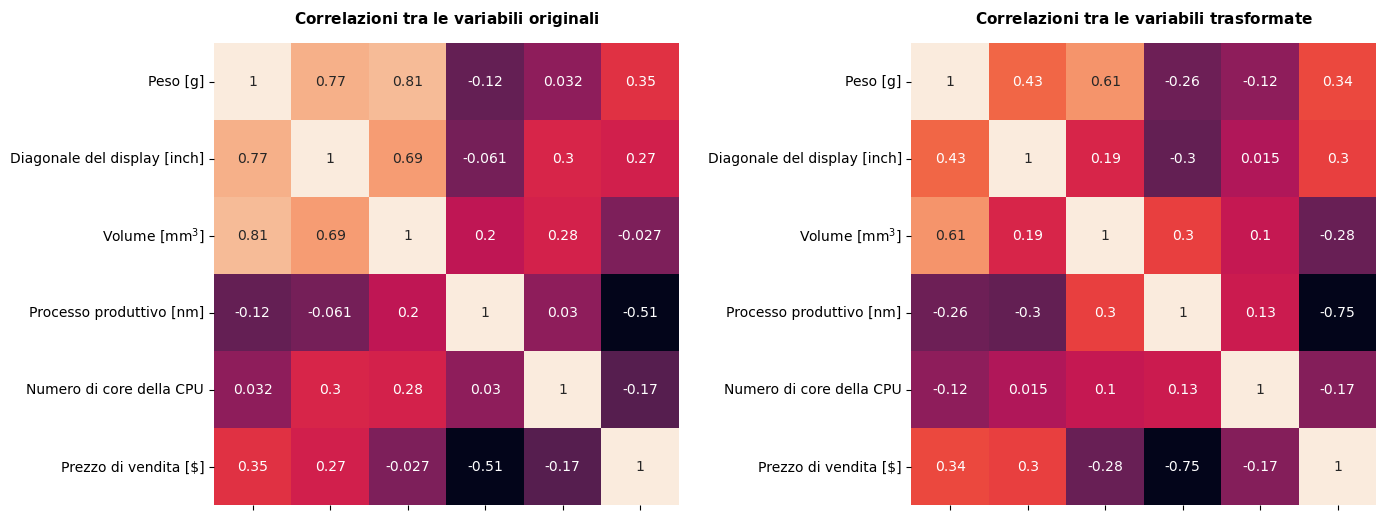

In [135]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(15, 6)
)
fig.subplots_adjust(
    wspace=.5
)

# correlazioni tra le variabili originali
sns.heatmap(
    data[num_vars + [target_var]].corr(),
    cbar=False,
    annot=True,
    ax=axes[0]
)
axes[0].set_title(
    "$\\mathbf{Correlazioni \\ tra \\ le \\ variabili \\ originali}$",
    size=11,
    y=1.025
)
axes[0].set(
    yticklabels=map.values(),
    xticklabels=[]
)

# correlazioni tra le variabili trasformate
sns.heatmap(
    tr_data[num_vars + [target_var]].corr(),
    cbar=False,
    annot=True,
    ax=axes[1]
)
axes[1].set_title(
    "$\\mathbf{Correlazioni \\ tra \\ le \\ variabili \\ trasformate}$",
    size=11,
    y=1.025
)
axes[1].set(
    yticklabels=map.values(),
    xticklabels=[]
);

# Scelta dei regressori 😎

## Funzione per costruire la formula in stile R

In [136]:
def build_formula(t_var, n_vars, c_vars):
    
    num_part = " + ".join(n_vars)
    cat_part = " + ".join([f"C({var_i})" for var_i in c_vars])
    formula_parts = [num_part, cat_part]
    formula = f"{t_var} ~ " + " + ".join([part_i for part_i in formula_parts if part_i])
    return formula

## Suddivisione del dataset in train e test

In [137]:
tr_train_data, tr_test_data = train_test_split(tr_data, train_size=.8, random_state=1)

## Stepwise backward
L'approccio **stepwise backward** è una tecnica di selezione delle variabili utilizzata per costruire modelli statistici, come la regressione lineare, in modo da migliorare la parsimonia e ridurre l'overfitting. Questo metodo rimuove iterativamente le variabili meno significative (quelle che peggiorano maggiormente la qualità del modello) finché non si raggiunge una configurazione ottimale.

### **Procedimento**
1. **Si inizia con il modello completo**: si parte con un modello che include tutte le variabili (sia numeriche che categoriali) disponibili.
2. **Calcolo della metrica di selezione**: per ogni iterazione, viene calcolata una metrica che misura la bontà del modello, come l'`AIC (Akaike Information Criterion)` o il `BIC (Bayesian Information Criterion)`. Questi criteri bilanciano la qualità dell'adattamento e la complessità del modello.
3. **Rimozione della variabile meno significativa**: si esamina ogni variabile nel modello e si calcola l'impatto della sua rimozione. Si rimuove la variabile che comporta il miglior miglioramento del criterio selezionato (ad esempio, il valore AIC più basso).
4. **Iterazione**: il processo viene ripetuto fino a quando non è possibile rimuovere altre variabili senza peggiorare significativamente la qualità del modello. Il processo si ferma quando l'eliminazione di ulteriori variabili non porta a un miglioramento del modello.
5. **Modello finale**: il risultato finale è un modello con un numero ridotto di variabili che sono considerate le più rilevanti.

### **Note**
- Riduce il rischio di overfitting.
- Seleziona variabili significative per il modello, migliorando l'interpretabilità.

### **AIC vs BIC**
| **Criterio**         | **AIC**                              | **BIC**                              |
|:--------------------:|:------------------------------------:|:------------------------------------:|
| **Formula**          | $-2\ln(L) + 2k$                      | $-2\ln(L) + k\cdot\ln(n)$            |
| **Approccio**        | Basato sulla predizione futura       | Basato sull'inferenza bayesiana      |
| **Bias**             | Favorisce modelli complessi          | Favorisce modelli semplici           |
| **Dataset grande**   | Più permissivo                       | Penalizza severamente modelli complessi  |
| **Dataset piccolo**  | Più affidabile per evitare underfitting  | Più soggetto a underfitting          |

In [138]:
def run_backward_stepwise(t_var, n_vars, c_vars, df, tolerance=1e-6):
    
    # inizializzazione della formula con tutte le variabili
    best_metric = smf.ols(
        formula=build_formula(t_var, n_vars, c_vars),
        data=df
    ).fit().aic
    current_vars = n_vars + c_vars
    print(f"AIC del modello completo: {round(best_metric, 2)}")

    while True:
        summary = pd.DataFrame()

        # calcolo dell'AIC per ogni possibile variabile da rimuovere
        for var in current_vars:
            vars_i = current_vars.copy()
            vars_i.remove(var)
            formula = build_formula(
                t_var,
                [v for v in vars_i if v in n_vars],
                [v for v in vars_i if v in c_vars]
            )
            metric_i = smf.ols(formula=formula, data=df).fit().aic
            summary = pd.concat(
                [
                    summary,
                    pd.DataFrame({"Removed variable": [var], "AIC": [metric_i]})
                ],
                ignore_index=True
            )
        
        # individuazione della variabile con l'AIC migliore
        best_candidate_idx = summary['AIC'].idxmin()
        best_candidate_aic = summary.loc[best_candidate_idx, "AIC"]
        var_to_remove = summary.loc[best_candidate_idx, "Removed variable"]
        
        # controllo: l'AIC è migliorato?
        if best_candidate_aic < best_metric - tolerance:
            best_metric = best_candidate_aic
            current_vars.remove(var_to_remove)
            print(f"- Variabile rimossa (AIC = {round(best_metric, 2)}): {var_to_remove}")
        else:
            break

    print(f"Variabili scelte:", sorted(current_vars))
    return [var for var in current_vars if var in n_vars], [var for var in current_vars if var in c_vars]

ch_num_vars, ch_cat_vars = run_backward_stepwise(target_var, num_vars.copy(), cat_vars.copy(), tr_train_data)

AIC del modello completo: 1399.06
- Variabile rimossa (AIC = 1397.06): nfc
- Variabile rimossa (AIC = 1395.31): foldable
- Variabile rimossa (AIC = 1394.26): display_size
Variabili scelte: ['chipset_brand', 'chipset_production_process', 'cpu_cores', 'phone_brand', 'price_range', 'store', 'volume', 'weight', 'year']


## Rimozione della multicollinearità tramite VIF

Il **VIF** (Variance Inflation Factor) consente di valutare la presenza di multicollinearità tra le variabili indipendenti in un modello di regressione.

### **Formula:**
$\text{VIF}_i = \frac{1}{1 - R_i^2}$
- $R_i^2$ rapresenta il coefficiente di determinazione della regressione della $i$-esima variabile indipendente sulle altre variabili indipendenti.

### **Interpretazione**
- $\text{VIF}_i = 1$: nessuna correlazione con le altre variabili.
- $1 < \text{VIF}_i \leq 5$: bassa correlazione, generalmente accettabile.
- $\text{VIF}_i > 5$: potenziale multicollinearità, da investigare.
- $\text{VIF}_i > 10$: multicollinearità severa, il modello potrebbe essere distorto.

In [139]:
def VIF_var_selection(n_vars, df):
    
    # inizializzazione: tutti i regressori numerici
    print(f"Variabili numeriche iniziali: {sorted(n_vars)}")
    current_vars = n_vars
    
    while True:
        
        # calcolo del VIF per ogni covariata
        subset = df[current_vars]
        summary = pd.DataFrame()
        summary["Variable"] = subset.columns
        summary["VIF"] = [variance_inflation_factor(subset.values, i) for i in range(len(subset.columns))]
        
        # il regressore con il VIF peggiore viene rimosso
        if summary["VIF"].max() > 5:
            print(f"- Variabile rimossa (VIF = {round(summary["VIF"].max(),2)}): {summary.loc[summary["VIF"].idxmax(), "Variable"]}")
            current_vars.remove(summary.loc[summary["VIF"].idxmax(), "Variable"])
        else:
            break
    
    print(f"Variabili numeriche scelte:", sorted(current_vars))
    return current_vars

ch_num_vars = VIF_var_selection(ch_num_vars.copy(), tr_data)

Variabili numeriche iniziali: ['chipset_production_process', 'cpu_cores', 'volume', 'weight']
Variabili numeriche scelte: ['chipset_production_process', 'cpu_cores', 'volume', 'weight']


# Stima di un modello di regressione multipla 👊

In [140]:
mhat = smf.ols(
    formula=build_formula(target_var, ch_num_vars, ch_cat_vars),
    data=tr_train_data
).fit()
mhat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_usd   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     80.89
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          9.17e-305
Time:                        19:51:48   Log-Likelihood:                -650.13
No. Observations:                1068   AIC:                             1394.
Df Residuals:                    1021   BIC:                             1628.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.8080      0.296      2.731      0.006       0.227       1.389
C(phone_brand)[T.Asus]             0.2813      0.186      1.513      0.131      -0.083       0.646
C(phone_brand)[T.Blackview]       -0.6221      0.266     -2.335      0.020      -1.145      -0.099
C(phone_brand)[T.Google]          -0.7270      0.284     -2.562      0.011      -1.284      -0.170
C(phone_brand)[T.Honor]           -0.0975      0.109     -0.896      0.370      -0.311       0.116
C(phone_brand)[T.Htc]             -0.0571      0.448     -0.128      0.899      -0.935       0.821
C(phone_brand)[T.Huawei]          -0.1558      0.139     -1.124      0.261      -0.428       0.116
C(phone_brand)[T.Infinix]         -0.3439      0.275     -1.251      0.211      -0.883       0.195
C(phone_brand)[T.Motorola]        -0.2394      0.090     -2.663      0.008      -0.416      -0.063
C(phone_brand)[T.Nokia]           -0.1003      0.117     -0.861      0.390      -0.329       0.128
C(phone_brand)[T.Nothing]         -0.1230      0.127     -0.965      0.335      -0.373       0.127
C(phone_brand)[T.Oneplus]         -0.2510      0.099     -2.534      0.011      -0.445      -0.057
C(phone_brand)[T.Oppo]            -0.2422      0.106     -2.281      0.023      -0.451      -0.034
C(phone_brand)[T.Realme]          -0.2077      0.101     -2.058      0.040      -0.406      -0.010
C(phone_brand)[T.Samsung]         -0.3373      0.085     -3.987      0.000      -0.503      -0.171
C(phone_brand)[T.Sony]             0.4481      0.167      2.685      0.007       0.121       0.776
C(phone_brand)[T.Tcl]             -0.3526      0.236     -1.493      0.136      -0.816       0.111
C(phone_brand)[T.Tecno]           -0.3032      0.321     -0.944      0.345      -0.934       0.327
C(phone_brand)[T.Vivo]             0.1613      0.160      1.005      0.315      -0.153       0.476
C(phone_brand)[T.Xiaomi]          -0.3949      0.082     -4.815      0.000      -0.556      -0.234
C(phone_brand)[T.Zte]             -0.1753      0.154     -1.139      0.255      -0.477       0.127
C(store)[T.Amazon DE]              0.0750      0.063      1.192      0.233      -0.048       0.198
C(store)[T.Amazon UK]              0.1427      0.064      2.213      0.027       0.016       0.269
C(store)[T.Amazon US]              0.0277      0.065      0.425      0.671      -0.100       0.155
C(store)[T.Best Buy]               0.2297      0.121      1.902      0.057      -0.007       0.467
C(store)[T.Motorola]               0.2755      0.219      1.257      0.209      -0.155       0.706
C(store)[T.Oneplus]                0.4167      0.335      1.244      0.214      -0.240       1.074
C(store)[T.Samsung]                0.2947      0.139      2.126      0.034       0.023       0.567
C(year)[T.2019

# Analisi dei residui 👀

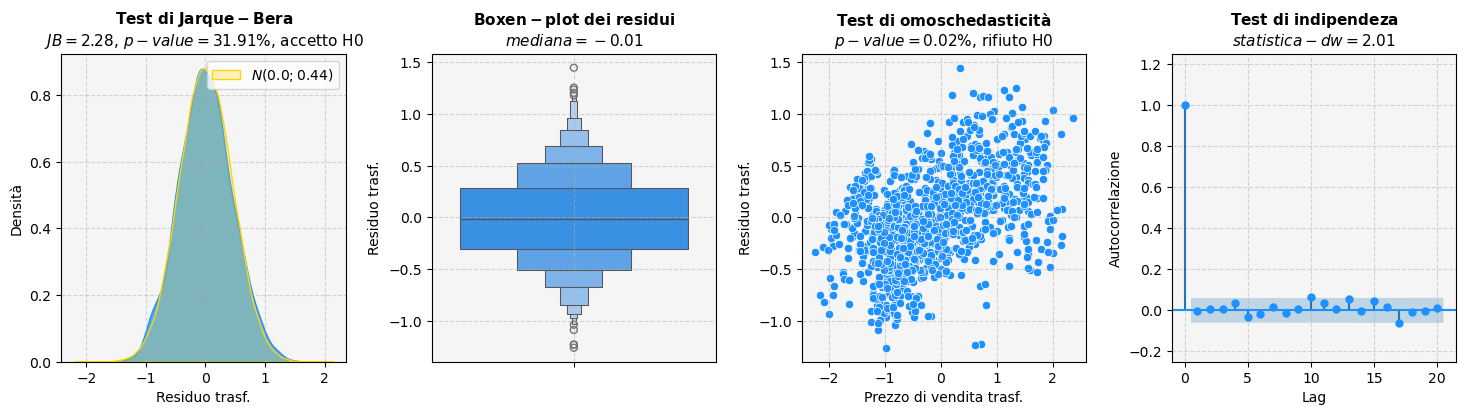

In [141]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
fig.subplots_adjust(
    wspace=.3,
    hspace=.45
)

residuals = mhat.resid

# test di normalità Jarque-Bera
jb, value = scipy.stats.jarque_bera(residuals)
sns.kdeplot(
    x=mhat.resid,
    color="dodgerblue",
    fill=True,
    alpha=.75,
    ax=axes[0]
)
sns.kdeplot(
    x=np.random.normal(loc=residuals.mean(), scale=residuals.std(),size=100000),
    color="gold",
    fill=True,
    alpha=.25,
    label="$N(" + str(round(residuals.mean(), 2)) + "; " + str(round(residuals.std(), 2)) + ")$",
    ax=axes[0]
)
axes[0].set_title(
    "$\\mathbf{Test \\ di \\ Jarque-Bera}$\n$JB=" + str(round(jb, 2)) + "$, $p-value=" + str(round(value*100, 2)) + "\\%$, accetto H0",
    size=11
)
axes[0].set(
    xlabel="Residuo trasf.",
    ylabel="Densità",
    facecolor="whitesmoke"
)
axes[0].grid(
    ls="--",
    alpha=.5,
)
axes[0].legend(
    loc="upper right"
)

# boxen-plot dei residui
sns.boxenplot(
    y=residuals,
    color="dodgerblue",
    ax=axes[1]
)
axes[1].set_title(
    "$\\mathbf{Boxen-plot \\ dei \\ residui}$\n$mediana=" + str(round(residuals.median(), 2)) + "$",
    size=11
)
axes[1].set(
    ylabel="Residuo trasf.",
    facecolor="whitesmoke"
)
axes[1].grid(
    ls="--",
    alpha=.5
)

# test di omoschedasticità Breusch-Pagan
_, pvalue, _, _ = het_breuschpagan(residuals, mhat.model.exog) 
sns.scatterplot(
    x=tr_train_data["price_usd"],
    y=residuals,
    color="dodgerblue",
    ax=axes[2]
)
axes[2].set_title(
    "$\\mathbf{Test \\ di \\ omoschedasticità}$\n$p-value=" + str(round(pvalue*100, 2)) + "\\%$, rifiuto H0",
    size=11
)
axes[2].set(
    ylabel="Residuo trasf.",
    xlabel="Prezzo di vendita trasf.",
    facecolor="whitesmoke"
)
axes[2].grid(
    ls="--",
    alpha=.5
)

# test di indipendenza Durbin-Watson
dw_statistic = durbin_watson(residuals)
plot_acf(
    residuals,
    lags=20,
    color="dodgerblue",
    ax=axes[3]
)
axes[3].set_title(
    "$\\mathbf{Test \\ di \\ indipendeza}$\n$statistica-dw=" + str(round(dw_statistic, 2)) + "$",
    size=11
)
axes[3].set(
    xlabel="Lag",
    ylabel="Autocorrelazione",
    ylim=(-.25, 1.25),
    facecolor="whitesmoke"
)
axes[3].grid(
    ls="--",
    alpha=.5
)

## Calcolo delle leverage

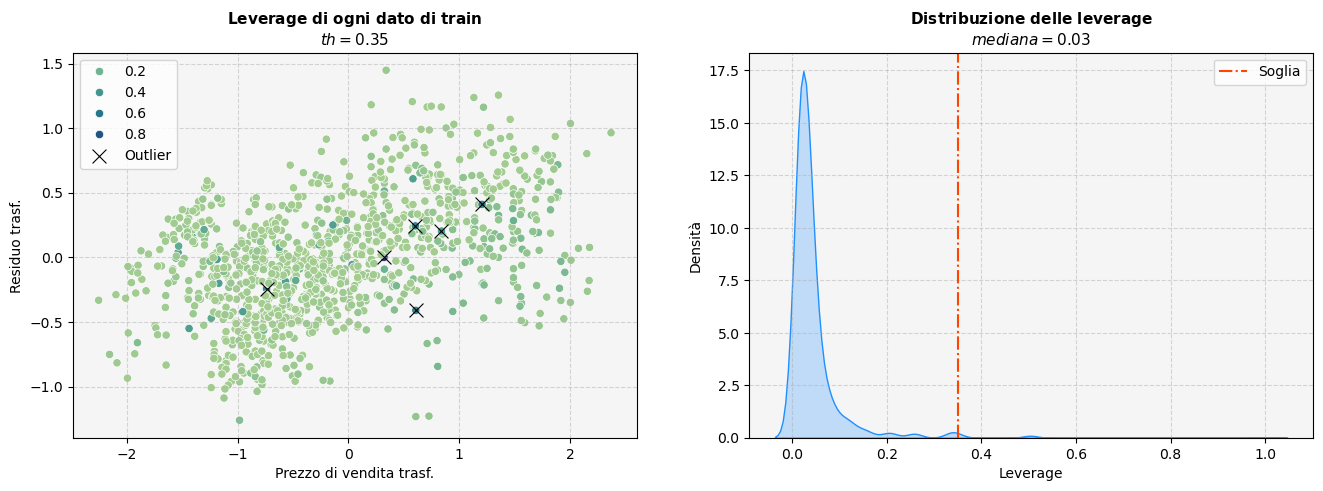

In [142]:
# calcolo della soglia e della leverage per ogni osservazione
th = 2*(mhat.df_model+1)/len(tr_test_data)
tr_train_data["leverage"] = mhat.get_influence().hat_matrix_diag
fig, axes = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(16, 5)
)

sns.scatterplot(
    data=tr_train_data,
    x="price_usd",
    y=residuals,
    hue=tr_train_data["leverage"],
    palette="crest",
    ax=axes[0]
)
sns.scatterplot(
    data=tr_train_data[tr_train_data.leverage >= th],
    x="price_usd",
    y=residuals,
    marker="x",
    s=100,
    color="black",
    label="Outlier",
    ax=axes[0]
)
axes[0].set_title(
    "$\\mathbf{Leverage \\ di \\ ogni \\ dato \\ di \\ train}$\n$th=" + str(round(th, 2)) + "$",
    size=11
)
axes[0].set(
    xlabel="Prezzo di vendita trasf.",
    ylabel="Residuo trasf.",
    facecolor="whitesmoke"
)
axes[0].grid(
    ls="--",
    alpha=.5
)

sns.kdeplot(
    x=tr_train_data["leverage"],
    fill=True,
    color="dodgerblue",
    ax=axes[1]
)
axes[1].axvline(
    th,
    color="orangered",
    ls="-.",
    label="Soglia"
)
axes[1].set_title(
    "$\\mathbf{Distribuzione \\ delle \\ leverage}$\n$mediana=" + str(round(tr_train_data.leverage.median(), 2)) + "$",
    size=11
)
axes[1].set(
    xlabel="Leverage",
    ylabel="Densità",
    facecolor="whitesmoke"
)
axes[1].grid(
    ls="--",
    alpha=.5
)
axes[1].legend();

# rimozione degli outlier
# tr_train_data = tr_train_data[tr_train_data.leverage < th]

[Torna al training del modello](#stepwise-backward)

# Validazione del modello 🍀

In [143]:
# train
real_price_usd = np.exp(scaler["price_usd"].inverse_transform(np.array(tr_train_data["price_usd"]).reshape(-1, 1)))
predicted_price_usd = np.exp(scaler["price_usd"].inverse_transform(np.array(mhat.fittedvalues).reshape(-1, 1)))
real_residuals = real_price_usd - predicted_price_usd
train_RMSE = np.sqrt(np.mean(real_residuals**2))
print(f"RMSE di train: {round(train_RMSE, 2)}$ (dev. std. dei residui: {round(real_residuals.std(), 2)}$)")

# test
real_price_usd = np.exp(scaler["price_usd"].inverse_transform(np.array(tr_test_data["price_usd"]).reshape(-1, 1)))
predicted_price_usd = np.exp(scaler["price_usd"].inverse_transform(np.array(mhat.predict(tr_test_data)).reshape(-1, 1)))
real_residuals = real_price_usd - predicted_price_usd
test_RMSE = np.sqrt(np.mean((real_price_usd - predicted_price_usd)**2))
print(f"RMSE di test: {round(test_RMSE, 2)}$ (dev. std. dei residui: {round(real_residuals.std(), 2)}$)")

RMSE di train: 166.52$ (dev. std. dei residui: 164.9$)
RMSE di test: 188.21$ (dev. std. dei residui: 188.18$)
